In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

In [2]:
import pynrc
from pynrc import nrc_utils
from astropy.io import fits

# Progress bar
from tqdm.auto import tqdm, trange

import os

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [3]:
opd_dir = 'NIRCAM_OPDS/'
save_dir = 'output/'

# Scenario to consider [best, nominal, requirements]
scenarios = ['Best Case', 'Nominal', 'Requirements']
# dwfe_vals = np.array([1.8, 3.1, 5.6])
dwfe_vals = np.array([0.7, 1.3, 3.5])

# LOS Jitter [2.5, 3.8, 5.8] per axis
jitter_modes = np.array([2.5, 3.8, 5.8, 0])
# jitter_modes = np.array([0, 3.8, 5.8])

# Target Acqs
# hdul_tacq = fits.open(opd_dir + 'TARGET_ACQ.fits')
# tacq_vals = np.array([hdu.data[0] for hdu in hdul_tacq])
tacq_vals = np.array([6.2568703,  8.759604 , 12.513741, 0])
# tacq_vals = np.array([0, 6.2568703,  8.759604 , 12.513741])

nsig = 5

In [4]:
def plot_contrasts(iwfe=None, ijitt=None, zoom=False, save=True):

    fig, axes = plt.subplots(3,3, figsize=(14,10), sharex=True, sharey=True)

    carr = ['C0', 'C1', 'C2']
    for i in range(3):
        for j in range(3):
            ax = axes[i,j]

            iwfe2  = i if iwfe  is None else iwfe
            ijitt2 = i if ijitt is None else ijitt
            itacq = j

            case = scenarios[iwfe2]
            jitt = jitter_modes[ijitt2]
            tacq = tacq_vals[itacq]

            fname = f'{fname0}_{case}_jit{jitt:.1f}mas_tacq{tacq:.1f}mas_contrast.npz'
            fname = fname.replace(' ','')

            if os.path.exists(save_dir + fname):
                res = np.load(save_dir + fname)
                # Plot file on all axes
                for ax2 in axes.flatten():
                    ax2.semilogy(res['rr'], res['contrast'], color=carr[i], lw=1, alpha=0.4)
            else:
                res['contrast'][:] = np.nan
                print(f"File doesn't exist: {fname}")

            # clim = np.sqrt(res['contrast']**2 + res['bg_sen_arr']**2)
            label = f'$\Delta$WFE={dwfe_vals[iwfe2]:.1f} nm; jitt={jitt:.1f} mas; TA={tacq:.1f} mas'
            ax.semilogy(res['rr'], res['contrast'], color=carr[i], lw=2.5, label=label)

            # Average sensitivity between 1-1.5"
            ind = (res['rr'] > 0.9) & (res['rr'] < 1.6)
            sen_mean = np.mean(res['sen_mag'][ind])
            sen_txt = f'{sen_mean:.1f} mag'
            ypos = 2 * np.mean(res['contrast'][ind])
            ax.text(1,ypos, sen_txt)
            # ax.text(1,1e-5, sen_txt)

            # Plut TA=0, jitter=0 case
            fname = f'{fname0}_{case}_jit0.0mas_tacq0.0mas_contrast.npz'
            fname = fname.replace(' ','')
            res = np.load(save_dir + fname)
            label = f'$\Delta$WFE={dwfe_vals[iwfe2]:.1f} nm; jitt=0.0 mas; TA=0.0 mas'
            ax.semilogy(res['rr'], res['contrast'], color=carr[i], lw=2, ls='--', alpha=0.3, label=label)

            # Background limit
            if not zoom:
                ax.plot(res['rr'], res['bg_sen_arr'], ls='--', color='C3', lw=1, label='BG Limit')
                
            # Set limits
            if zoom:
                ax.set_ylim([1e-6,1e-2])
                ax.set_xlim([0,1.59])
            else:
                ax.set_ylim([1e-8,1e-2])
                ax.set_xlim([0,5])

            if j>0: 
                ax.set_ylabel('')
            else:
                ax.set_ylabel(f'{nsig}-{sig_str} Contrast')
                # ax.set_ylabel(f'{case} ($\Delta$WFE={dwfe_vals[iwfe]:.1f} nm)')
            if i<2:
                ax.set_xlabel('')
            else:
                ax.set_xlabel('Separation (acsec)')
                # ax.set_xlabel(f'TA Offset = {tacq:.1f} mas (per axis)')

            ax.legend()

            # Lambda/D
            ax2 = ax.twiny()
            xlim2 = np.array(ax.get_xlim()) / (206265 * 4.3e-6 / 6.5)
            ax2.set_xlim(xlim2)
            if i==0:
                ax2.set_xlabel('$\lambda/D$')
            else:
                ax2.get_xaxis().set_ticklabels([])

            # Magnitudes
            ax2 = ax.twinx()
            ylim2 = 3.3 - 2.5 * np.log10(np.array(ax.get_ylim()))
            ax2.set_ylim(ylim2)
            if j==2:
                ax2.set_ylabel(f'{nsig}-{sig_str} Sensitivity [mags]')
            else:
                ax2.get_yaxis().set_ticklabels([])

    if iwfe is not None:
        fig.suptitle(f'{filt} + {mask} -- {case} Scenario', fontsize=14)
    else:
        fig.suptitle(f'{filt} + {mask}', fontsize=14)
    fig.tight_layout()

    fig.subplots_adjust(wspace=0.03, hspace=0.05)

    if save:
        fout = f'{fname0}_matrix_contrasts'
        if zoom:
            fout = f'{fout}_zoom'
        if iwfe is not None:
            fout = f'{fout}_{case}'
        fout = fout + '.pdf'
        fout = fout.replace(' ', '')
        
        print(f'Saving: {save_dir + fout}')
        fig.savefig(save_dir + fout)


In [134]:
def plot_diff_images(iwfe=None, ijitt=None, itacq=None, save=True):

    fig, axes = plt.subplots(3,3, figsize=(10,10), sharex=True, sharey=True)

    for i in range(3):
        for j in range(3):
            iwfe2  = i if iwfe  is None else iwfe
            ijitt2 = i if ijitt is None else ijitt
            itacq2 = j if itacq is None else itacq

            case = scenarios[iwfe2]
            jitt = jitter_modes[ijitt2]
            tacq = tacq_vals[itacq2]

            fname = f'{fname0}_{case}_jit{jitt:.1f}mas_tacq{tacq:.1f}mas_diff2.fits'
            fname = fname.replace(' ','')

            ax = axes[i,j]
            if os.path.exists(save_dir + fname):
                hdul = fits.open(save_dir + fname)
                plot_hdulist(hdul, ax=ax, colorbar=False, cmap='RdBu_r', axes_color='k', vmin=-1, vmax=1)
            else:
                # If it doesn't exist yet, plot a fake one
                print(f"File doesn't exist: {fname}")
                hdul[0].data[:] = 0
                plot_hdulist(hdul, ax=ax, colorbar=False, cmap='RdBu_r', axes_color='k', vmin=-1, vmax=1)

            im = hdul[0].data
            im_rho = dist_image(im, pixscale=hdul[0].header['PIXELSCL'])
            std = np.std(im[(im_rho>0.5) & (im_rho<2)])          
            # Add circle indicate std calculation
            circ = mpatches.Circle((0,0), radius=2, fill=False, ls='--')
            ax.add_patch(circ)
            circ = mpatches.Circle((0,0), radius=0.5, fill=False, ls='--')
            ax.add_patch(circ)
            el_str = "$\mathdefault{e}^-$"
            std_str = f'$\sigma$ = {std:.3f} {el_str}/sec'
            ax.text(0,2.3, std_str, ha='center')

            if j>0: 
                ax.set_ylabel('')
            else:
                ax.set_ylabel(f'$\Delta$WFE={dwfe_vals[iwfe2]:.1f} nm; jitter={jitt:.1f}mas')
            if i<2:
                ax.set_xlabel('')
            else:
                ax.set_xlabel(f'TA Offset = {tacq:.1f} mas (per axis)')

    if iwfe is not None:
        fig.suptitle(f'{filt} + {mask} -- {case} Scenario', fontsize=14)
    else:
        fig.suptitle(f'{filt} + {mask}', fontsize=14)
    fig.tight_layout()

    fig.subplots_adjust(wspace=0.01)
    fig.subplots_adjust(hspace=0.02)

    if save:
        fout = f'{fname0}_matrix_diff_images'
        if iwfe is not None:
            fout = f'{fout}_{case}'
        fout = fout + '.pdf'
        fout = fout.replace(' ', '')
        
        print(f'Saving: {save_dir + fout}')
        fig.savefig(save_dir + fout)
    

# Differenced images

In [6]:
filt, mask = ('F430M', 'MASK430R')
fname0 = f'{filt}_{mask}'

In [7]:
file_list = [file for file in os.listdir(save_dir) if ("diff2.fits" in file) and (fname0 in file)]
file_list = np.sort(file_list)

In [8]:
file_list

array(['F430M_MASK430R_BestCase_jit0.0mas_tacq0.0mas_diff2.fits',
       'F430M_MASK430R_BestCase_jit2.5mas_tacq12.5mas_diff2.fits',
       'F430M_MASK430R_BestCase_jit2.5mas_tacq6.3mas_diff2.fits',
       'F430M_MASK430R_BestCase_jit2.5mas_tacq8.8mas_diff2.fits',
       'F430M_MASK430R_BestCase_jit3.8mas_tacq12.5mas_diff2.fits',
       'F430M_MASK430R_BestCase_jit3.8mas_tacq6.3mas_diff2.fits',
       'F430M_MASK430R_BestCase_jit3.8mas_tacq8.8mas_diff2.fits',
       'F430M_MASK430R_BestCase_jit5.8mas_tacq12.5mas_diff2.fits',
       'F430M_MASK430R_BestCase_jit5.8mas_tacq6.3mas_diff2.fits',
       'F430M_MASK430R_BestCase_jit5.8mas_tacq8.8mas_diff2.fits',
       'F430M_MASK430R_Nominal_jit0.0mas_tacq0.0mas_diff2.fits',
       'F430M_MASK430R_Nominal_jit2.5mas_tacq12.5mas_diff2.fits',
       'F430M_MASK430R_Nominal_jit2.5mas_tacq6.3mas_diff2.fits',
       'F430M_MASK430R_Nominal_jit2.5mas_tacq8.8mas_diff2.fits',
       'F430M_MASK430R_Nominal_jit3.8mas_tacq12.5mas_diff2.fits',
       'F4

In [9]:
from pynrc.nb_funcs import plot_hdulist
from pynrc.nrc_utils import radial_std, pad_or_cut_to_size, dist_image
import matplotlib.patches as mpatches

In [11]:
sig_str = r'$\mathdefault{\sigma}$'
mu_str = r'$\mathdefault{\mu m}$'

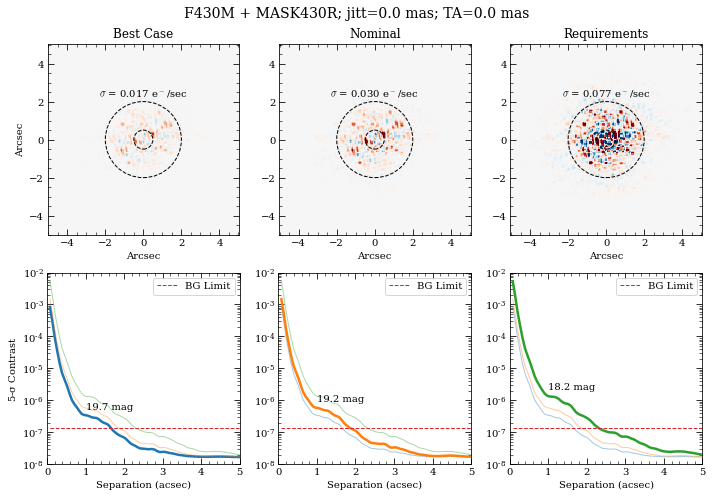

In [132]:
# WFE drifts with tacq=0 and jitt=0

fig, axes = plt.subplots(2,3, figsize=(10,7), sharex=False, sharey=False)

for i in range(3):
    iwfe  = i
    ijitt = -1
    itacq = -1

    case = scenarios[iwfe]
    jitt = jitter_modes[ijitt]
    tacq = tacq_vals[itacq]

    fname = f'{fname0}_{case}_jit{jitt:.1f}mas_tacq{tacq:.1f}mas_diff2.fits'
    fname = fname.replace(' ','')
        
    ax = axes[0,i]
    vmin, vmax = np.array([-1,1]) * 0.2
    if os.path.exists(save_dir + fname):
        hdul = fits.open(save_dir + fname)
        plot_hdulist(hdul, ax=ax, colorbar=False, cmap='RdBu_r', axes_color='k', vmin=vmin, vmax=vmax)
    else:
        # If it doesn't exist yet, plot a fake one
        print(f"File doesn't exist: {fname}")
        hdul[0].data[:] = 0
        plot_hdulist(hdul, ax=ax, colorbar=False, cmap='RdBu_r', axes_color='k', vmin=vmin, vmax=vmax)

    if i!=0:
        ax.set_ylabel('')
        
    im = hdul[0].data
    im_rho = dist_image(im, pixscale=hdul[0].header['PIXELSCL'])
    std = np.std(im[(im_rho>0.5) & (im_rho<2)])          
    # Add circle indicate std calculation
    circ = mpatches.Circle((0,0), radius=2, fill=False, ls='--')
    ax.add_patch(circ)
    circ = mpatches.Circle((0,0), radius=0.5, fill=False, ls='--')
    ax.add_patch(circ)
    el_str = "$\mathdefault{e}^-$"
    std_str = f'$\sigma$ = {std:.3f} {el_str}/sec'
    ax.text(0,2.3, std_str, ha='center')

    ax.set_title(case)

    
carr = ['C0', 'C1', 'C2']
for i in range(3):
    ax = axes[1,i]

    iwfe  = i
    ijitt = -1
    itacq = -1

    case = scenarios[iwfe]
    jitt = jitter_modes[ijitt]
    tacq = tacq_vals[itacq]
    fname = f'{fname0}_{case}_jit{jitt:.1f}mas_tacq{tacq:.1f}mas_contrast.npz'
    fname = fname.replace(' ','')

    # Plot file on all axes
    if os.path.exists(save_dir + fname):
        res = np.load(save_dir + fname)
        for ax2 in axes[1,:].flatten():
            ax2.semilogy(res['rr'], res['contrast'], color=carr[i], lw=1, alpha=0.4)
            
    # clim = np.sqrt(res['contrast']**2 + res['bg_sen_arr']**2)
    ax.semilogy(res['rr'], res['contrast'], color=carr[i], lw=2.5)
    ax.plot(res['rr'], res['bg_sen_arr'], ls='--', color='C3', lw=1, label='BG Limit')
    ax.set_ylim([1e-8,1e-2])
    ax.set_xlim([0,5])

    if i==0:
        ax.set_ylabel(f'{nsig}-{sig_str} Contrast')
    ax.set_xlabel('Separation (acsec)')

    ax.legend()

    # Average sensitivity between 1-1.5"
    ind = (res['rr'] > 0.9) & (res['rr'] < 1.6)
    sen_mean = np.mean(res['sen_mag'][ind])
    sen_txt = f'{sen_mean:.1f} mag'
    ypos = 2 * np.mean(res['contrast'][ind])
    ax.text(1,ypos, sen_txt)
                
fig.suptitle(f'{filt} + {mask}; jitt={jitt:.1f} mas; TA={tacq:.1f} mas', fontsize=14)
fig.tight_layout()

# fig.subplots_adjust(wspace=0.01)
# fig.subplots_adjust(hspace=0.02)

fig.savefig(save_dir + f'{fname0}_matrix_diff_images_jitt0_tacq0.pdf')

Saving: output/F430M_MASK430R_matrix_diff_images.pdf


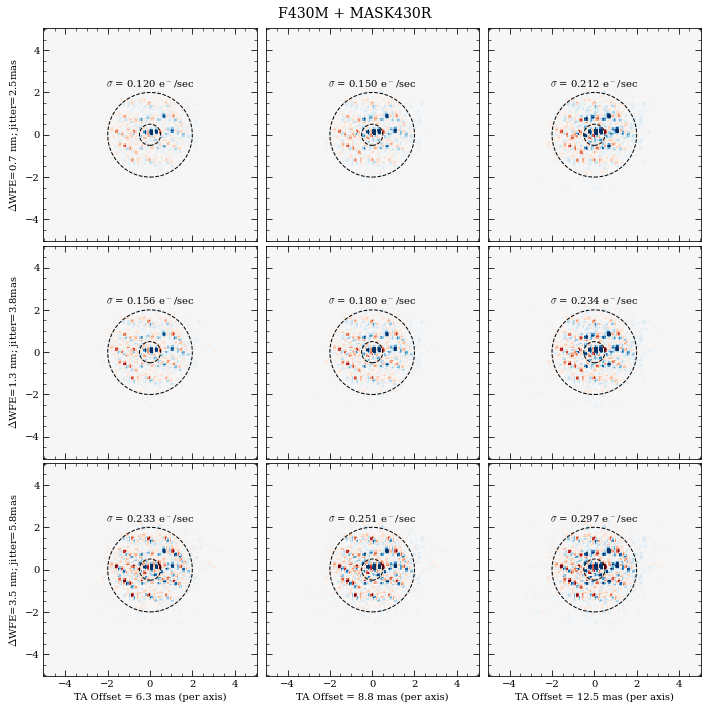

In [135]:
plot_diff_images()

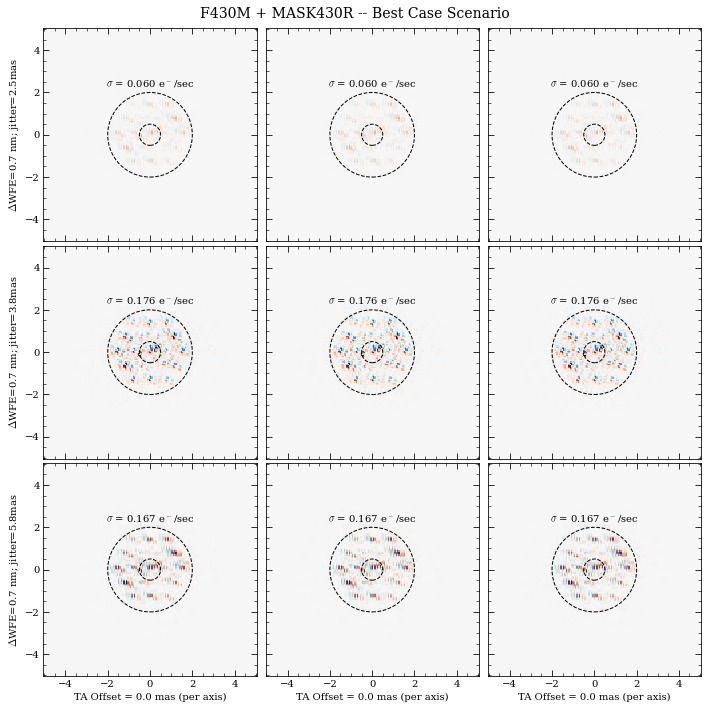

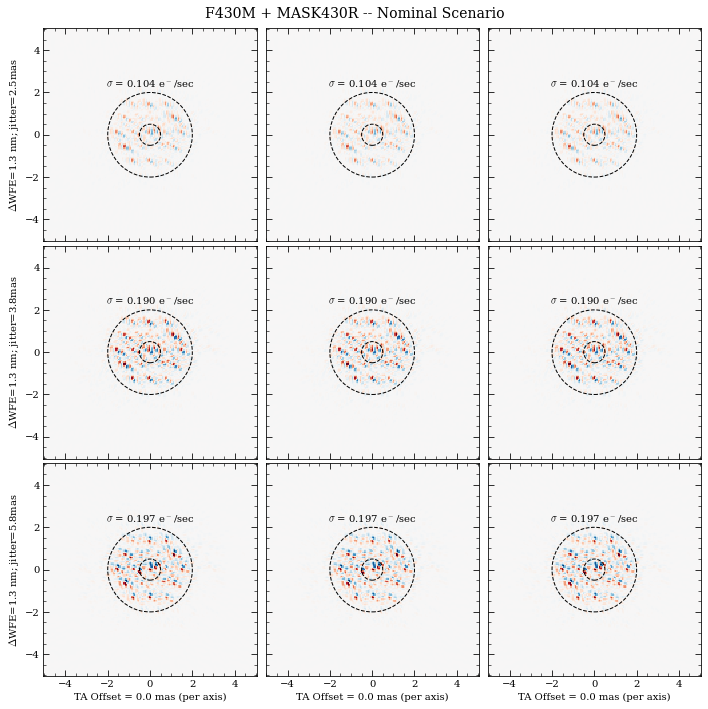

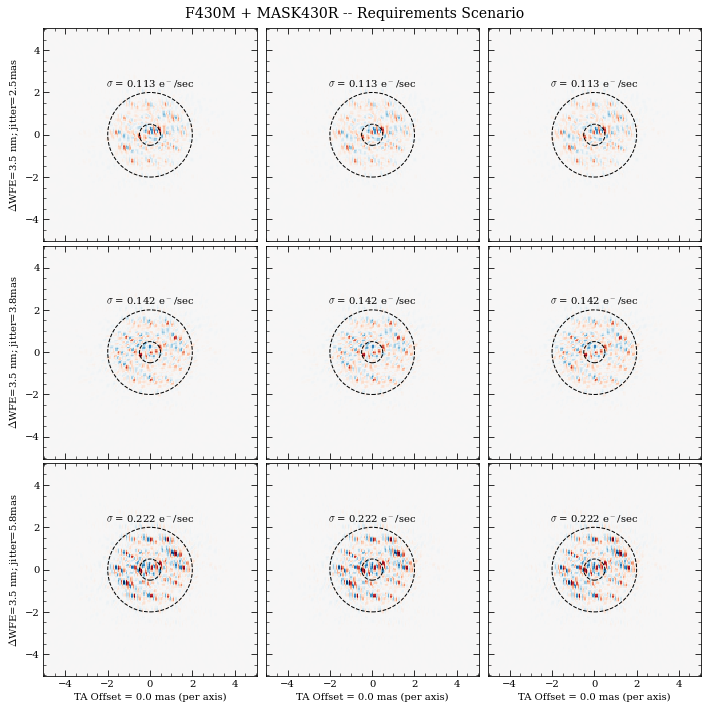

In [131]:
for iwfe in [0, 1, 2]:
    plot_diff_images(iwfe=iwfe, itacq=-1, save=False)

In [ ]:
for iwfe in [None, 0, 1, 2]:
    plot_contrasts(iwfe=iwfe, ijitt=None, zoom=True)

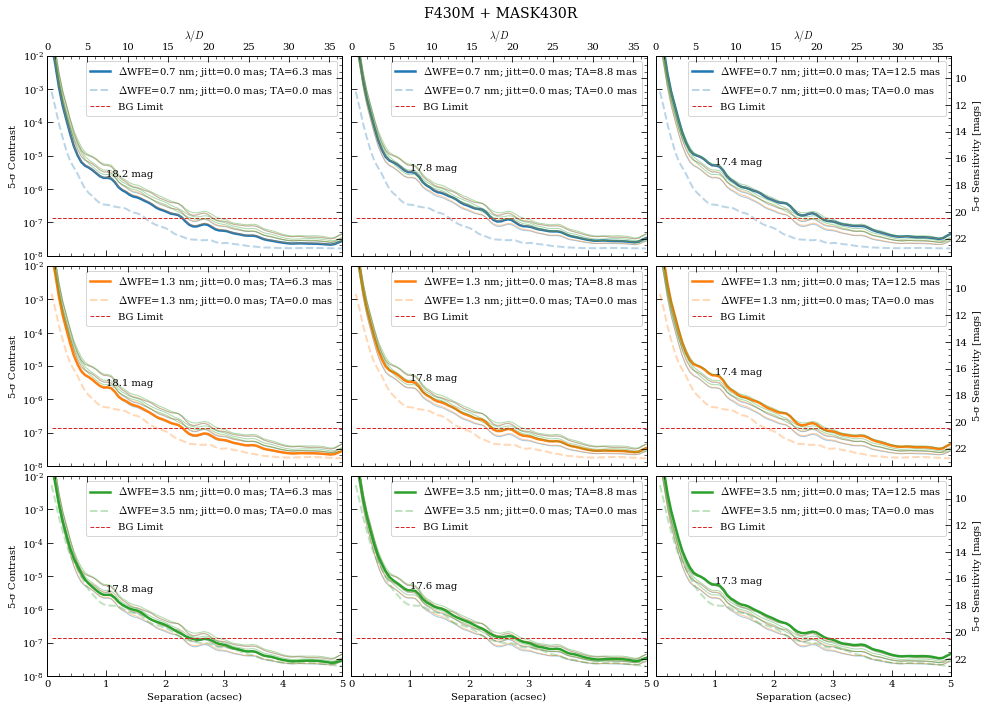

In [39]:
plot_contrasts(iwfe=None, ijitt=-1, save=False)

In [23]:
jj = np.arange(3)
tacq_vals[jj]

array([ 6.2568703,  8.759604 , 12.513741 ])

In [24]:
tacq_ref = np.array([6.2568703,  8.759604 , 12.513741, 0])
tacq_ref = tacq_ref.repeat(2).reshape([-1,2])

In [36]:
tacq_ref[jj,0]

array([ 6.2568703,  8.759604 , 12.513741 ])

In [142]:
rms_arr = []
mag_arr = []
mag2_arr = []
for case in scenarios:
    print()
    for jitt in np.sort(jitter_modes):
        print()
        for tacq in np.sort(tacq_vals):
            fname1 = f'{fname0}_{case}_jit{jitt:.1f}mas_tacq{tacq:.1f}mas_diff2.fits'
            fname2 = f'{fname0}_{case}_jit{jitt:.1f}mas_tacq{tacq:.1f}mas_contrast.npz'
            fname1 = fname1.replace(' ', '')
            fname2 = fname2.replace(' ', '')
            if os.path.exists(save_dir + fname1) and os.path.exists(save_dir + fname2):
                hdul = fits.open(save_dir + fname1)
                res = np.load(save_dir + fname2)

                # Average sensitivity between 1-1.5"
                ind = (res['rr'] > 0.9) & (res['rr'] < 1.6)
                sens_mean = np.mean(res['sen_mag'][ind])
                cont_mean = np.mean(res['contrast'][ind])
                mag_arr.append(sens_mean)
                mag2_arr.append(-2.5*np.log10(cont_mean))
                
                # RMS of differenced image
                im = hdul[0].data
                im_rho = dist_image(im, pixscale=hdul[0].header['PIXELSCL'])
                rms = np.std(im[(im_rho>0.5) & (im_rho<2)])
                rms_arr.append(rms)
                hdul.close()
        
                print(fname1, f'{rms:.2f} {-2.5*np.log10(cont_mean):.1f}')
        
rms_arr = np.array(rms_arr)
mag_arr = np.array(mag_arr)
mag2_arr = np.array(mag2_arr)



F430M_MASK430R_BestCase_jit0.0mas_tacq0.0mas_diff2.fits 0.02 16.4
F430M_MASK430R_BestCase_jit0.0mas_tacq6.3mas_diff2.fits 0.08 14.8
F430M_MASK430R_BestCase_jit0.0mas_tacq8.8mas_diff2.fits 0.12 14.4
F430M_MASK430R_BestCase_jit0.0mas_tacq12.5mas_diff2.fits 0.20 13.9

F430M_MASK430R_BestCase_jit2.5mas_tacq0.0mas_diff2.fits 0.06 15.1
F430M_MASK430R_BestCase_jit2.5mas_tacq6.3mas_diff2.fits 0.12 14.3
F430M_MASK430R_BestCase_jit2.5mas_tacq8.8mas_diff2.fits 0.15 14.1
F430M_MASK430R_BestCase_jit2.5mas_tacq12.5mas_diff2.fits 0.21 13.8

F430M_MASK430R_BestCase_jit3.8mas_tacq0.0mas_diff2.fits 0.18 13.9
F430M_MASK430R_BestCase_jit3.8mas_tacq6.3mas_diff2.fits 0.10 14.5
F430M_MASK430R_BestCase_jit3.8mas_tacq8.8mas_diff2.fits 0.14 14.2
F430M_MASK430R_BestCase_jit3.8mas_tacq12.5mas_diff2.fits 0.21 13.8

F430M_MASK430R_BestCase_jit5.8mas_tacq0.0mas_diff2.fits 0.17 14.0
F430M_MASK430R_BestCase_jit5.8mas_tacq6.3mas_diff2.fits 0.15 14.1
F430M_MASK430R_BestCase_jit5.8mas_tacq8.8mas_diff2.fits 0.18 13.9
F4

[12.08 -2.5 ]


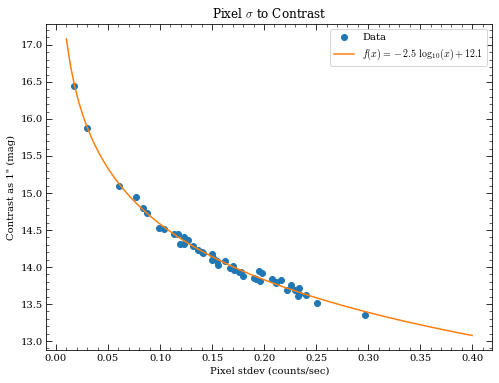

In [157]:
# plt.plot(rms_arr, mag_arr, marker='o', ls='none')
plt.plot(rms_arr, mag2_arr, marker='o', ls='none', label='Data')
cf = nrc_utils.jl_poly_fit(np.log10(rms_arr), mag2_arr, deg=1)
cf = np.array([12.08,-2.5])

print(cf)

x = np.logspace(np.log10(0.01), np.log10(0.3), 100)
x = np.linspace(0.01, 0.4, 100)
label = r'$f(x) = -2.5~\log_{10}(x) + 12.1$'
plt.plot(x, nrc_utils.jl_poly(np.log10(x), cf), label=label)
plt.xlabel('Pixel stdev (counts/sec)')
plt.ylabel('Contrast as 1" (mag)')
plt.title(r'Pixel $\sigma$ to Contrast')

plt.legend()

[0.00161631 0.02246087]


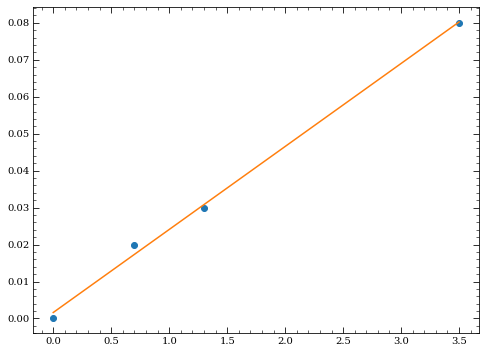

In [127]:
x, y_init = np.sort(jitter_modes), np.array([0.02, 0.06, 0.15, 0.17])
y = np.sqrt(y_init**2 - np.min(y_init)**2)

x, y_init = np.sort(tacq_vals), np.array([0.02, 0.08, 0.12, 0.2])
y = np.sqrt(y_init**2 - np.min(y_init)**2)

x, y = np.array([0, 0.7, 1.3, 3.5]), np.array([0, 0.02, 0.03, 0.08])

cf = nrc_utils.jl_poly_fit(x,y,deg=1)
plt.plot(x, y, marker='o', ls='none')
xf = np.linspace(0,x.max(), 100)
yf = nrc_utils.jl_poly(xf, cf)
plt.plot(xf, yf)

print(cf)